More playing with PCA. This notebook primarily uses PCA to look at differences between subjects, conditions, and reps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
roi = 'A1'
filepath = 'drive/MyDrive/fMRI_music_data/%s_by_subject_sorted_conds/'%roi
subjects = ['03','15','20','23']
n_sub = len(subjects)

In [3]:
# load in the data from all subjects
data = []
for subj in subjects: 
  data.append(np.load(filepath+'%s_sub-1%s.npy'%(roi,subj)))

# recast the list into an array and check the shape
data = np.asarray(data)
print(data.shape)

(4, 516, 1776)


In [4]:
# reshape the data into conditions and runs
n_sub = len(subjects)
n_voxels = data.shape[1]
n_TRs = 148
n_conds = 4
n_reps = 3

orig_data = np.copy(data)
orig_data = np.reshape(orig_data,(n_sub,n_voxels,n_TRs,n_conds,n_reps),order='F')
print(orig_data.shape)

(4, 516, 148, 4, 3)


In [5]:
# normalize within each run and subject
# matrix has to be time (n_samples) x voxels (n_features)
orig_data_norm = np.zeros_like(orig_data)
for s in range(n_sub):
  for c in range(n_conds):
    for r in range(n_reps):
      this_data_norm = StandardScaler().fit_transform(orig_data[s,:,:,c,r].T)
      orig_data_norm[s,:,:,c,r] = this_data_norm.T

In [6]:
# check a voxel
print(np.mean(orig_data_norm[0,20,:,0,0])) # should be 0
print(np.std(orig_data_norm[0,20,:,0,0])) # should be 1

# check a time point
print(np.mean(orig_data_norm[0,:,20,0,0])) # shouldn't be 0
print(np.std(orig_data_norm[0,:,20,0,0])) # shouldn't be 1

-2.700542492331462e-17
1.0
-0.12873016131392562
0.7968813653413711


Fit and transform each subject individually. Save the explained variance for each model and plot to compare between-subject variability. Try it first with rep 1 of Intact.

In [ ]:
# grab the data for each subject for rep 1 of Intact
data_rep1_I = orig_data_norm[:,:,:,0,0]
print(data_rep1_I.shape)

(4, 516, 148)


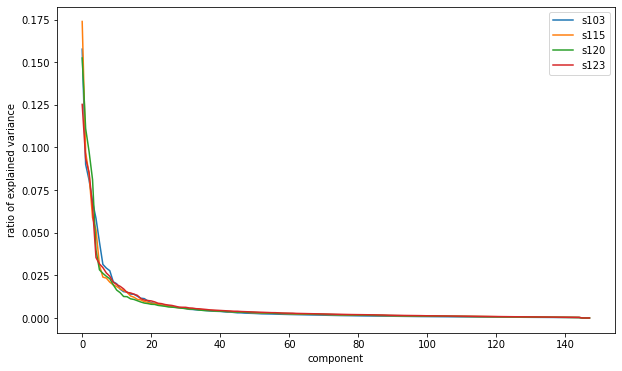

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('component')
ax.set_ylabel('ratio of explained variance')

for s in range(n_sub):
  # create the object
  this_pca = PCA()

  # fit and transform this subject's data
  # data has to be TRs x voxels for PCA
  #this_data_PCs = this_pca.fit_transform(data_rep1_I[s,:,:].T)
  # don't need to transform and store if we just want explained variance ratio
  this_pca.fit(data_rep1_I[s,:,:].T)

  # plot the explained variance
  ax.plot(this_pca.explained_variance_ratio_,label='s1%s'%subjects[s])

ax.legend();

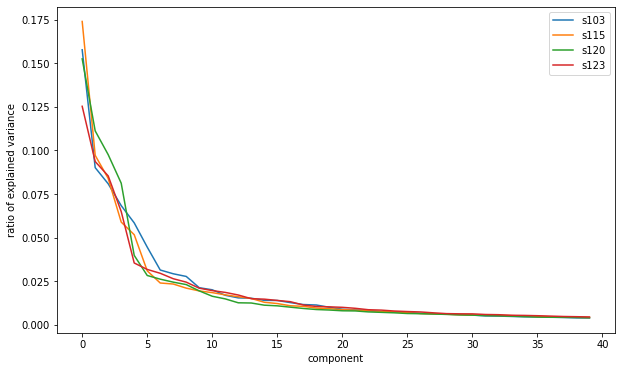

In [ ]:
# same thing, but zoom in on the first 40 components
fig,ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('component')
ax.set_ylabel('ratio of explained variance')

for s in range(n_sub):
  # create the object
  this_pca = PCA()

  # fit this subject's data
  # data has to be TRs x voxels for PCA
  this_pca.fit(data_rep1_I[s,:,:].T)

  # plot the explained variance
  ax.plot(this_pca.explained_variance_ratio_[:40],label='s1%s'%subjects[s])

ax.legend();

Something similar across different reps and conditions. Average over subjects and fit PCA on different runs.

In [ ]:
# average over subjects
avg_data_all = np.mean(orig_data_norm,axis=0)
print(avg_data_all.shape)

(516, 148, 4, 3)


In [ ]:
conds = ['I','8B','2B','1B']
ls = ['solid','dashed','dashdot','dotted'] # one linestyle for each condition
color = ['red','green','blue'] # one color for each rep

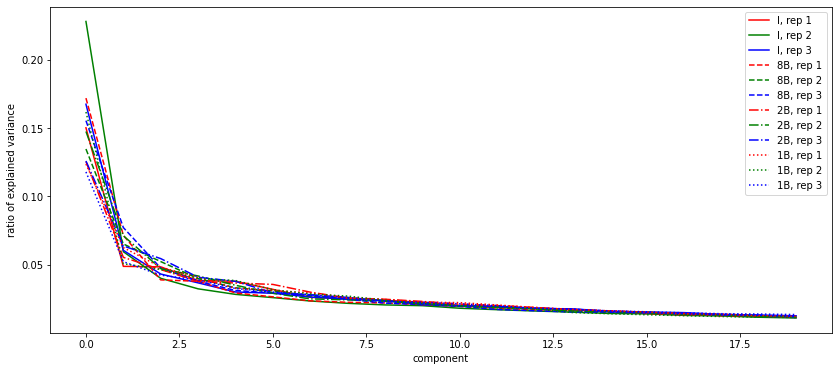

In [ ]:
fig,ax = plt.subplots(figsize=(14,6))
ax.set_xlabel('component')
ax.set_ylabel('ratio of explained variance')

for c in range(n_conds):
  for r in range(n_reps):
    # create the object
    this_pca = PCA()

    # fit the data for this run
    this_pca.fit(avg_data_all[:,:,c,r].T)

    # plot the explained variance
    ax.plot(this_pca.explained_variance_ratio_[:20],
            label='%s, rep %d'%(conds[c],r+1),
            color=color[r],
            ls=ls[c],
            )

ax.legend();

Subject clusters - For each run, fit PCA for the average over subjects, then transform each subject individually.

In [7]:
# for reference
print(orig_data_norm.shape)

(4, 516, 148, 4, 3)


In [13]:
n_components = n_TRs
data_PCs = np.zeros((n_sub,n_components,n_TRs,n_conds,n_reps))

for c in range(1):#n_conds):
  for r in range(1):#n_reps):
    # grab the data for this condition and rep
    this_data = orig_data_norm[:,:,:,c,r]

    # create the PCA object
    this_pca = PCA()

    # average over all subjects to fit PCA
    this_data_avg = np.mean(this_data,axis=0)
    this_pca.fit(this_data_avg.T)

    # transform each subject's data individually and save
    for s in range(1):#n_sub):
      this_sub_PCs = this_pca.transform(this_data[s,:,:].T)
      data_PCs[s,:,:,c,r] = this_sub_PCs

As a test, with only the first rep of I in the first subject transformed - how does the run traverse the 3D space defined by the first three PCs?

In [24]:
test_TRxPC = data_PCs[0,:,:,0,0]
print(test_TRxPC.shape) # PCs x TRs
print(test_TRxPC[:3,:].shape) # first three PCs

(148, 148)
(3, 148)


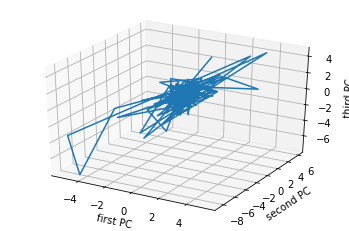

In [27]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('first PC')
ax.set_ylabel('second PC')
ax.set_zlabel('third PC')

ax.plot(test_TRxPC[0,:],test_TRxPC[1,:],test_TRxPC[2,:]);

Text(0, 0.5, 'third PC')

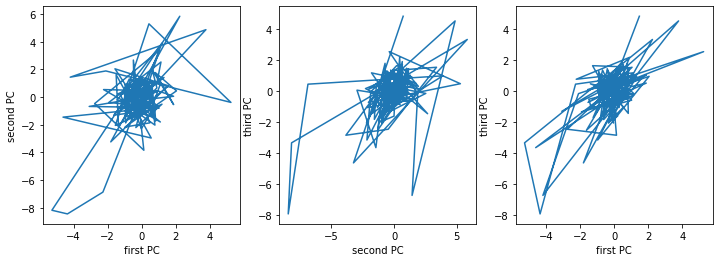

In [28]:
# plot each projection
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(test_TRxPC[0,:],test_TRxPC[1,:])
ax[0].set_xlabel('first PC')
ax[0].set_ylabel('second PC')

ax[1].plot(test_TRxPC[1,:],test_TRxPC[2,:])
ax[1].set_xlabel('second PC')
ax[1].set_ylabel('third PC')

ax[2].plot(test_TRxPC[0,:],test_TRxPC[2,:])
ax[2].set_xlabel('first PC')
ax[2].set_ylabel('third PC')

Split the run according to section boundaries (HRF = 3).

In [37]:
HRF = 3
section_boundaries = np.array((1,39,75,102,141))
sb = section_boundaries + HRF
colors = ['black','red','green','blue','pink','black']
print(sb)

[  4  42  78 105 144]


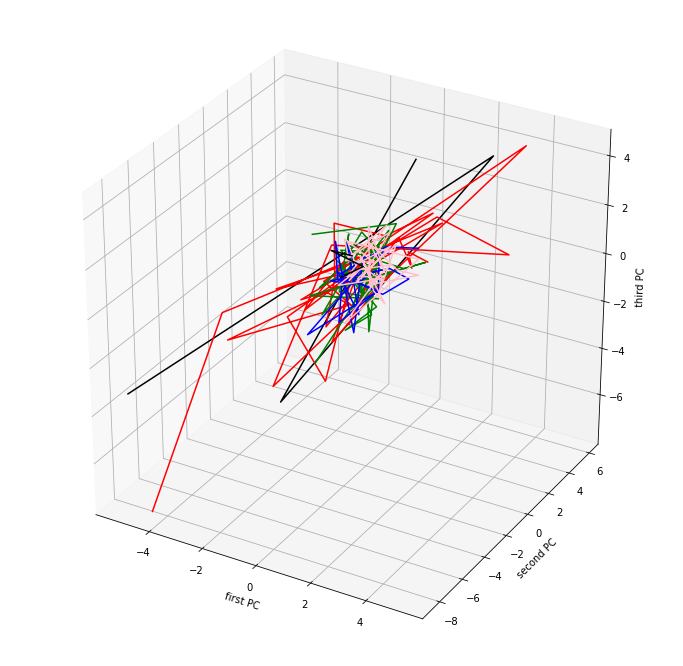

In [41]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.set_xlabel('first PC')
ax.set_ylabel('second PC')
ax.set_zlabel('third PC')

ax.plot(test_TRxPC[0,:sb[0]],
        test_TRxPC[1,:sb[0]],
        test_TRxPC[2,:sb[0]],
        color=colors[0])
for b in range(1,len(colors)-1):
  ax.plot(test_TRxPC[0,sb[b-1]:sb[b]],
          test_TRxPC[1,sb[b-1]:sb[b]],
          test_TRxPC[2,sb[b-1]:sb[b]],
          color=colors[b])
ax.plot(test_TRxPC[0,sb[-1]:],
        test_TRxPC[1,sb[-1]:],
        test_TRxPC[2,sb[-1]:],
        color=colors[-1]);

In [60]:
HRF = 3
section_boundaries = np.array((1,39,75,102,141))
sb = section_boundaries + HRF
colors = ['black','red','green','blue','pink','black']

def plot_PCs_2d(ax,PC1,PC2,x_data,y_data,bound=sb,colors=colors):
  ax.set_xlabel('PC %d'%(PC1+1))
  ax.set_ylabel('PC %d'%(PC2+1))
  ax.plot(x_data[:sb[0]],y_data[:sb[0]],color=colors[0])
  for b in range(1,bound.shape[0]):
    ax.plot(x_data[sb[b-1]:sb[b]],y_data[sb[b-1]:sb[b]],color=colors[b])
  ax.plot(x_data[sb[-1]:],y_data[sb[-1]:],color=colors[-1])

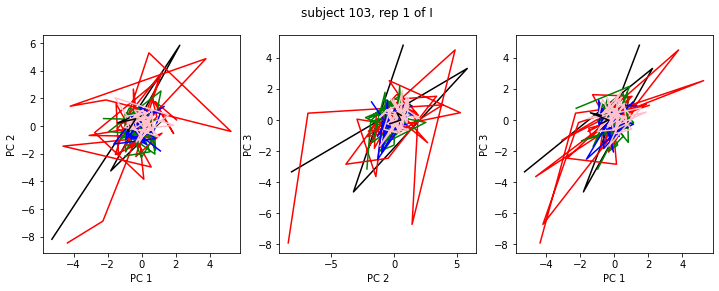

In [66]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
plot_PCs_2d(ax[0],0,1,test_TRxPC[0,:],test_TRxPC[1,:])
plot_PCs_2d(ax[1],1,2,test_TRxPC[1,:],test_TRxPC[2,:])
plot_PCs_2d(ax[2],0,2,test_TRxPC[0,:],test_TRxPC[2,:])
fig.suptitle('subject 103, rep 1 of I');

In [ ]:
n_components = n_TRs
data_PCs = np.zeros((n_sub,n_components,n_TRs,n_conds,n_reps))

for c in range(1):#n_conds):
  for r in range(1):#n_reps):
    # grab the data for this condition and rep
    this_data = orig_data_norm[:,:,:,c,r]

    # create the PCA object
    this_pca = PCA()

    # average over all subjects to fit PCA
    this_data_avg = np.mean(this_data,axis=0)
    this_pca.fit(this_data_avg.T)

    # transform each subject's data individually and save
    for s in range(1):#n_sub):
      this_sub_PCs = this_pca.transform(this_data[s,:,:].T)
      data_PCs[s,:,:,c,r] = this_sub_PCs

Run clusters - For each subject, fit PCA for all of the runs, then transform each run individually.